# Nested ANOVA - one between factor
Reference: http://www.flutterbys.com.au/stats/tut/tut9.2b.html

In [2]:
import pandas as pd
import numpy as np
 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pymc3 as pm
print(pm.__version__)
import patsy

3.3


### Data loading

In [3]:
#curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies = pd.read_csv('../datasets/curdies.csv')
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [4]:
labels_SITE = ['{}{}'.format(curdies['SITE'][i], curdies['SEASON'][j][0]) for i, j in zip(curdies['SITE'].index, curdies['SEASON'].index)]
labels_SITE = sorted(list(set(labels_SITE)))
labels_SITE

['1W', '2W', '3W', '4S', '5S', '6S']

In [5]:
#curdies.dropna(axis=0, inplace=True)
#curdies.reset_index(inplace=True)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [6]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies.head(10)

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1W,0.647683,0.897100
1,WINTER,1W,6.096152,1.571317
2,WINTER,1W,1.310564,1.069953
3,WINTER,1W,1.725279,1.146080
4,WINTER,1W,1.459387,1.099114
5,WINTER,1W,1.057561,1.014090
6,WINTER,2W,1.016298,1.004050
7,WINTER,2W,16.196794,2.006122
8,WINTER,2W,1.168081,1.039605
9,WINTER,2W,1.024299,1.006020


In [7]:
curdies_agg = curdies.groupby(by=['SEASON', 'SITE'], as_index=False).mean()
curdies_agg.dropna(axis=0, inplace=True)
curdies_agg.reset_index(inplace=True)
curdies_agg

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,2.049437,1.132942
1,1,WINTER,2W,4.181908,1.271870
2,2,WINTER,3W,0.678206,0.867871
3,9,SUMMER,4S,0.419095,0.350821
4,10,SUMMER,5S,0.229086,0.180462
5,11,SUMMER,6S,0.194244,0.381122


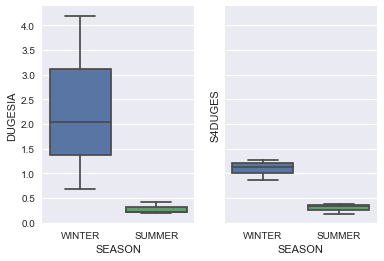

In [8]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

## Fit hierarchical model
I will use the matrix parametrization

In [9]:
#X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
#X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)
X

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [10]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [11]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [27]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=1, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfNormal('sigma_Z', sd=1)
    
    # Centered version
    #gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfNormal('sigma', sd=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=3000, chains=4, njobs=2, tune=1500, nuts_kwargs=dict(target_accept=.99)) # remove step=pm.NUTS() to allow auto initialization

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z_offset, sigma_Z_log__, beta_X]
The number of effective samples is smaller than 25% for some parameters.


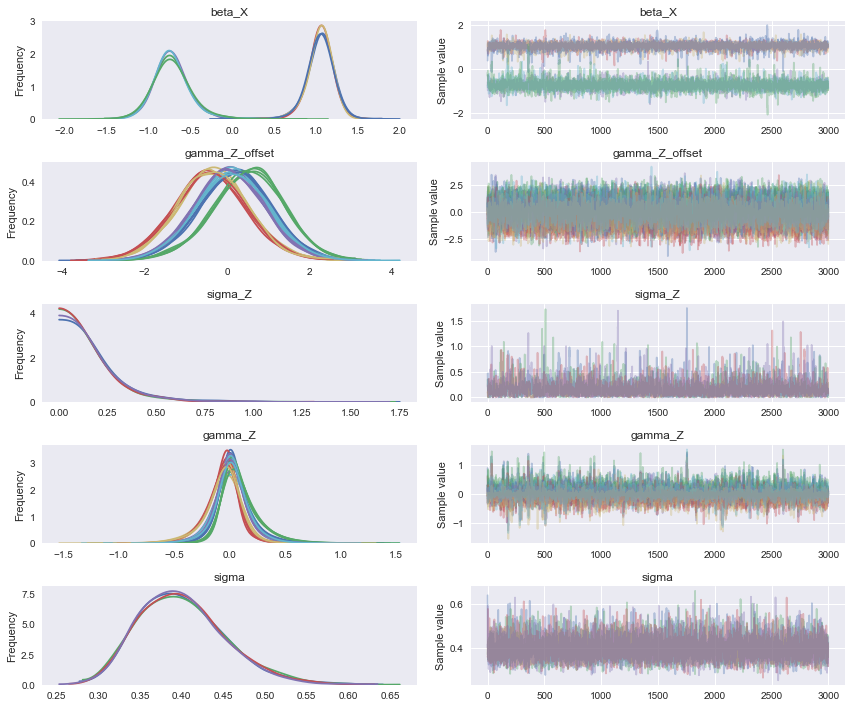

In [28]:
_ = pm.traceplot(trace)

In [29]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.045880,0.160644,0.002875,0.722341,1.333741,3419.171443,1.000111
beta_X__1,-0.722807,0.217699,0.004132,-1.164868,-0.291524,3111.668573,0.999922
gamma_Z_offset__0,0.199918,0.865881,0.011143,-1.521041,1.917235,7316.993010,1.000149
gamma_Z_offset__1,0.517947,0.861735,0.010444,-1.228350,2.212798,6711.690022,0.999981
gamma_Z_offset__2,-0.400276,0.882843,0.011118,-2.192983,1.308921,6444.717398,1.000115
gamma_Z_offset__3,0.055197,0.858018,0.009366,-1.635869,1.762620,6582.700157,0.999906
gamma_Z_offset__4,-0.324331,0.860694,0.009689,-1.967740,1.429781,7919.815155,0.999887
gamma_Z_offset__5,0.135923,0.861821,0.010051,-1.607501,1.810813,7816.947264,0.999910
sigma_Z,0.164691,0.154849,0.003455,0.000034,0.459933,2406.033732,1.001194
gamma_Z__0,0.045618,0.160416,0.002809,-0.254873,0.385217,3631.504553,1.000257


### Investigate divergences

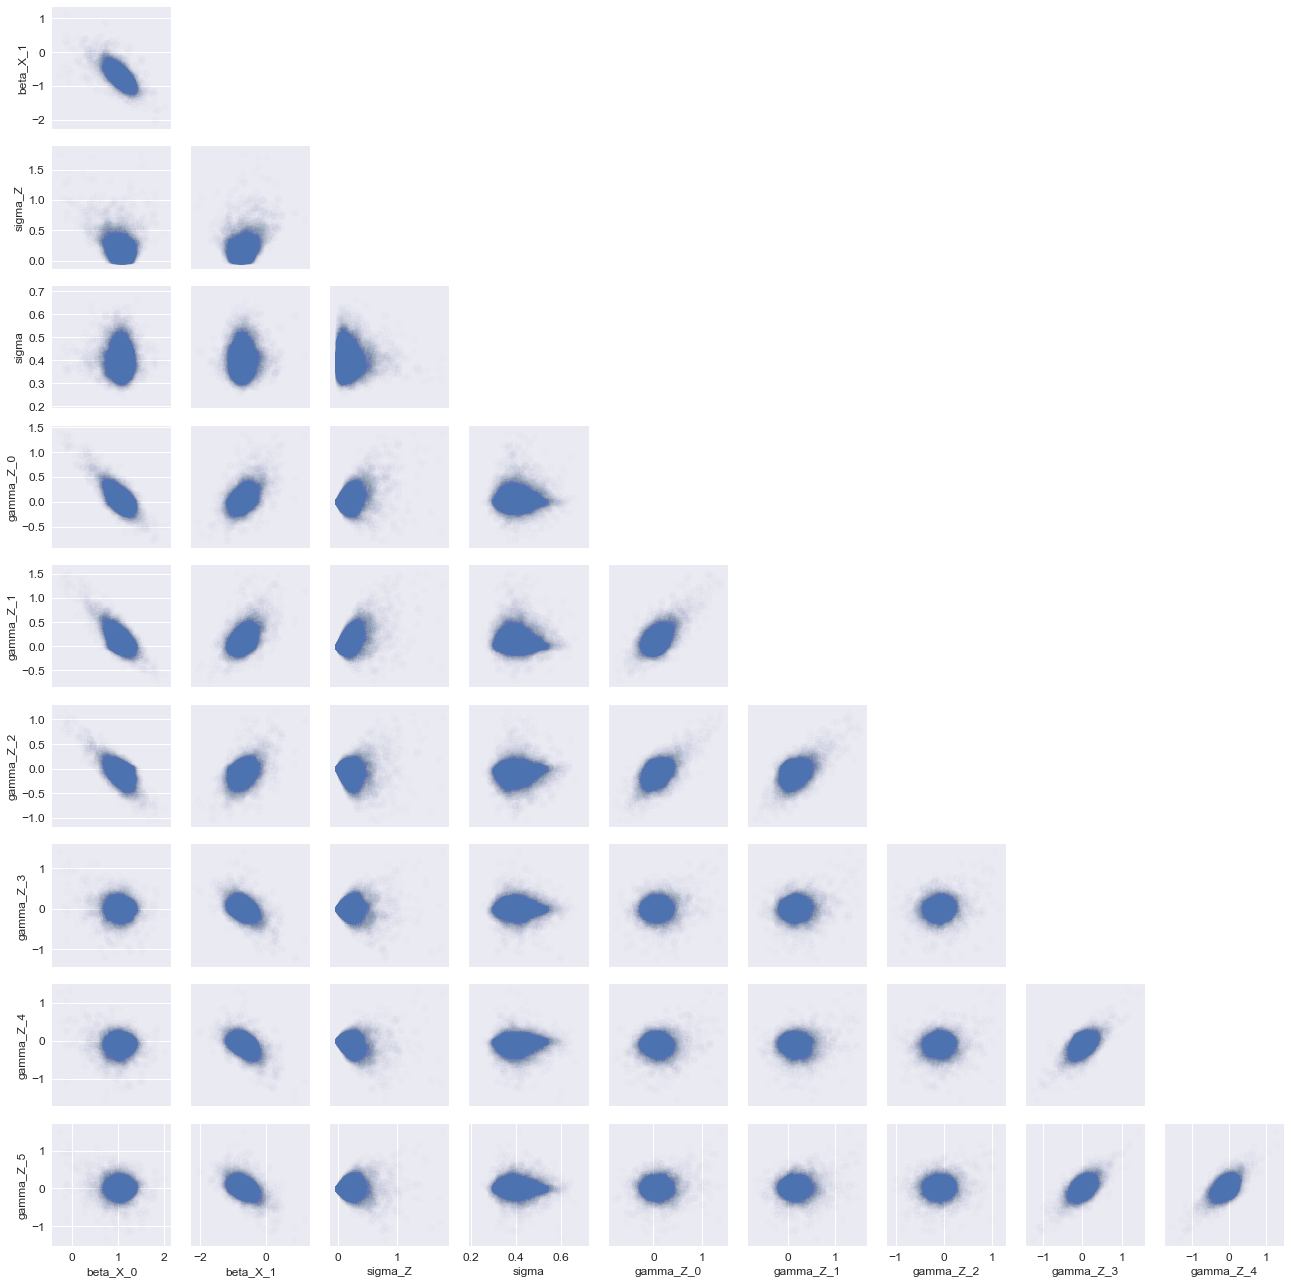

In [30]:
pm.pairplot(trace, varnames=['beta_X', 'sigma_Z', 'sigma', 'gamma_Z'], divergences=True, alpha=.01);

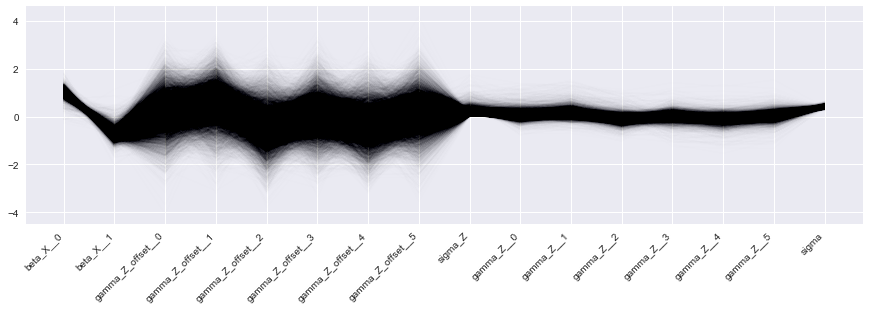

In [47]:
tracedf = pm.trace_to_dataframe(trace)
divergent = trace['diverging']

_, ax = plt.subplots(1, 1, figsize=(15, 4))
ax.plot(tracedf.values[divergent == 0].T, color='k', alpha=.005)
if any(divergent):
    ax.plot(tracedf.values[divergent == 1].T, color='C2', lw=1)
        
labels = tracedf.columns
ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation = 45, ha="right");

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000017141D8E6A0>,
      dtype=object)

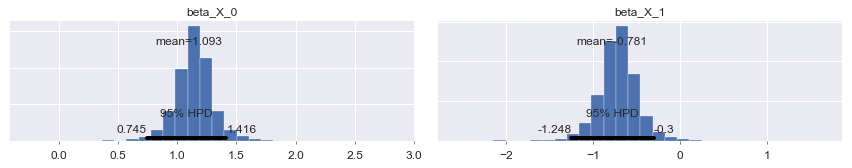

In [24]:
pm.plot_posterior(trace, varnames=['beta_X'])

The `beta_X` seems to be close enough

In [25]:
curdies.groupby(['SEASON'])[['S4DUGES']].mean()

,S4DUGES
SEASON,
WINTER,1.090894
SUMMER,0.304135


The `sigma` seems to be ok

In [26]:
curdies.groupby(['SEASON'])['S4DUGES'].std().mean()

0.3847746117705029

In [27]:
mcmc_X = trace['beta_X']

In [28]:
fit_X = np.dot(np.asarray(mcmc_X), X.T)

In [29]:
fit_X.mean(axis=0)

array([1.09264995, 1.09264995, 1.09264995, 1.09264995, 1.09264995,
       1.09264995, 1.09264995, 1.09264995, 1.09264995, 1.09264995,
       1.09264995, 1.09264995, 1.09264995, 1.09264995, 1.09264995,
       1.09264995, 1.09264995, 1.09264995, 0.31164416, 0.31164416,
       0.31164416, 0.31164416, 0.31164416, 0.31164416, 0.31164416,
       0.31164416, 0.31164416, 0.31164416, 0.31164416, 0.31164416,
       0.31164416, 0.31164416, 0.31164416, 0.31164416, 0.31164416,
       0.31164416])

In [30]:
mcmc_Z = trace['gamma_Z']

In [31]:
fit_Z = np.dot(np.asarray(mcmc_Z), Z.T)

In [32]:
fit_Z.mean(axis=0)

array([ 0.0203476 ,  0.0203476 ,  0.0203476 ,  0.0203476 ,  0.0203476 ,
        0.0203476 ,  0.08135723,  0.08135723,  0.08135723,  0.08135723,
        0.08135723,  0.08135723, -0.1017288 , -0.1017288 , -0.1017288 ,
       -0.1017288 , -0.1017288 , -0.1017288 ,  0.01558523,  0.01558523,
        0.01558523,  0.01558523,  0.01558523,  0.01558523, -0.06227003,
       -0.06227003, -0.06227003, -0.06227003, -0.06227003, -0.06227003,
        0.02937682,  0.02937682,  0.02937682,  0.02937682,  0.02937682,
        0.02937682])

In [33]:
fit = fit_X + fit_Z

In [34]:
curdies['S4DUGES_FIT'] = fit.mean(axis=0)

In [35]:
curdies

,SEASON,SITE,DUGESIA,S4DUGES,S4DUGES_FIT
0,WINTER,1W,0.647683,0.897100,1.112998
1,WINTER,1W,6.096152,1.571317,1.112998
2,WINTER,1W,1.310564,1.069953,1.112998
3,WINTER,1W,1.725279,1.146080,1.112998
4,WINTER,1W,1.459387,1.099114,1.112998
5,WINTER,1W,1.057561,1.014090,1.112998
6,WINTER,2W,1.016298,1.004050,1.174007
7,WINTER,2W,16.196794,2.006122,1.174007
8,WINTER,2W,1.168081,1.039605,1.174007
9,WINTER,2W,1.024299,1.006020,1.174007


## Alternative parametrization (hierarchical)

In [36]:
X = patsy.dmatrix('SEASON', data=curdies_agg, return_type='dataframe')
X = np.asarray(X)
X # the size should be (n_sites, n_seasons), that is the number of row should be equal to the number of random factors

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 1.],
       [1., 1.],
       [1., 1.]])

In [41]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=estimate_X, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 392 divergences after tuning. Increase `target_accept` or reparameterize.
There were 295 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


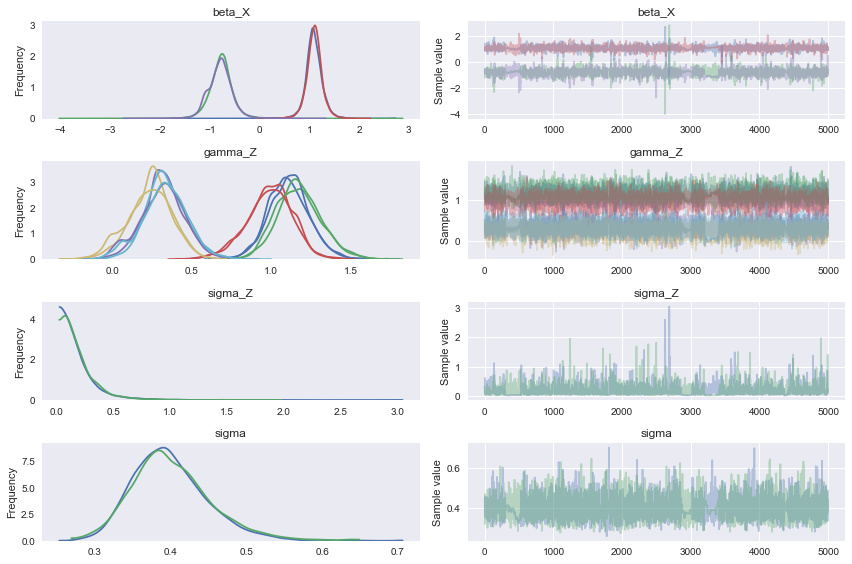

In [42]:
_ = pm.traceplot(trace)

In [39]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.077617,0.159200,0.004771,0.816902,1.409216,674.0,1.000233
beta_X__1,-0.768232,0.223125,0.005943,-1.200924,-0.388854,1040.0,1.001901
gamma_Z__0,1.090827,0.124009,0.004733,0.867586,1.347554,193.0,1.000232
gamma_Z__1,1.137016,0.138282,0.006719,0.903832,1.419975,90.0,1.003048
gamma_Z__2,0.998538,0.130158,0.004222,0.713949,1.237885,261.0,1.006202
gamma_Z__3,0.325844,0.121455,0.004504,0.096914,0.571698,148.0,1.006581
gamma_Z__4,0.267253,0.128752,0.005480,-0.003124,0.483847,53.0,1.016459
gamma_Z__5,0.336500,0.123020,0.004833,0.100501,0.580772,97.0,1.010042
sigma_Z,0.150044,0.169820,0.008027,0.020377,0.428125,73.0,1.014434
sigma,0.393194,0.050628,0.002058,0.306256,0.498195,168.0,1.001738


## Standardize values

In [33]:
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)

In [34]:
Y = np.asarray(curdies.S4DUGES)
Y

array([0.8970995, 1.5713175, 1.0699526, 1.1460797, 1.0991136, 1.0140897,
       1.0040498, 2.0061216, 1.0396048, 1.0060202, 1.1908882, 1.3845343,
       0.9111253, 1.0507807, 1.0271582, 0.9002881, 0.6074385, 0.7104333,
       0.       , 0.       , 0.9849349, 0.       , 0.       , 1.1199931,
       1.0827734, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.6037669, 0.       , 0.9006648, 0.7823021])

In [35]:
Y = (Y-Y.mean())/Y.std()
Y

array([ 0.36485678,  1.59738083,  0.68084598,  0.82001236,  0.7341546 ,
        0.57872416,  0.56037042,  2.39223725,  0.62536779,  0.56397247,
        0.90192586,  1.2559263 ,  0.39049706,  0.64579822,  0.60261441,
        0.3706858 , -0.16466653,  0.02361615, -1.27511234, -1.27511234,
        0.52542687, -1.27511234, -1.27511234,  0.77232398,  0.70428342,
       -1.27511234, -1.27511234, -1.27511234, -1.27511234, -1.27511234,
       -1.27511234, -1.27511234, -0.1713785 , -1.27511234,  0.37137443,
        0.15499802])

In [36]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=50, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=3) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=2, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


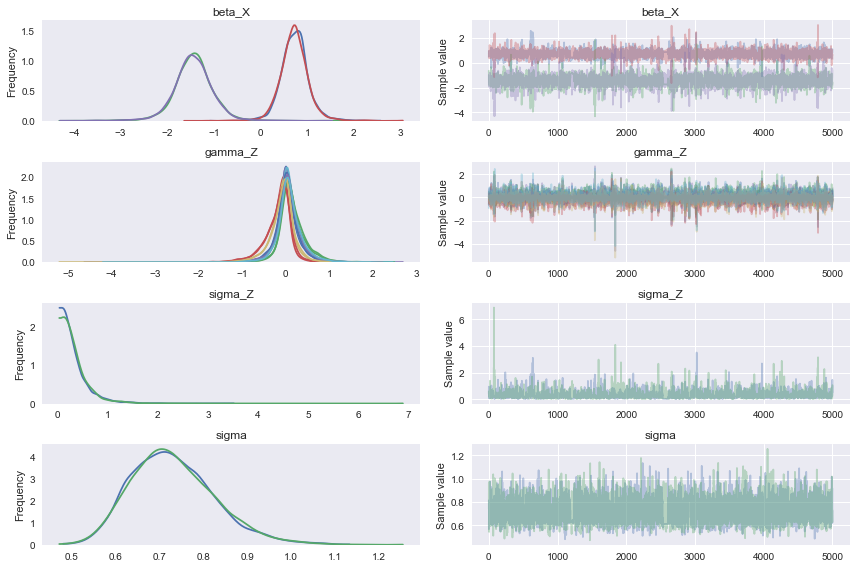

In [37]:
_ = pm.traceplot(trace)

In [38]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,0.724970,0.310144,0.006283,0.149756,1.342779,2123.0,0.999964
beta_X__1,-1.447537,0.440658,0.008511,-2.297313,-0.610275,2964.0,0.999934
gamma_Z__0,0.024668,0.296083,0.005758,-0.570109,0.628597,3194.0,1.000156
gamma_Z__1,0.140224,0.310929,0.005921,-0.400455,0.859987,2580.0,1.000484
gamma_Z__2,-0.186409,0.321790,0.007136,-0.912717,0.353210,1842.0,0.999911
gamma_Z__3,0.042155,0.298581,0.003721,-0.555017,0.667956,5571.0,1.000013
gamma_Z__4,-0.094929,0.307537,0.004344,-0.729943,0.492139,5238.0,0.999974
gamma_Z__5,0.063920,0.303068,0.003719,-0.479587,0.750398,5438.0,1.000459
sigma_Z,0.333935,0.300615,0.008634,0.036034,0.870286,1120.0,1.000795
sigma,0.731630,0.095146,0.001534,0.561772,0.924762,3776.0,1.000332


## Re-fit after removing missing values from dataset

In [39]:
curdies = pd.read_csv('../datasets/curdies.csv', na_values=0)
curdies.head()

,SEASON,SITE,DUGESIA,S4DUGES
0,WINTER,1,0.647683,0.897100
1,WINTER,1,6.096152,1.571317
2,WINTER,1,1.310564,1.069953
3,WINTER,1,1.725279,1.146080
4,WINTER,1,1.459387,1.099114


In [40]:
curdies.dropna(axis=0, inplace=True)
curdies.reset_index(inplace=True)
curdies.head()

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1,0.647683,0.897100
1,1,WINTER,1,6.096152,1.571317
2,2,WINTER,1,1.310564,1.069953
3,3,WINTER,1,1.725279,1.146080
4,4,WINTER,1,1.459387,1.099114


In [41]:
curdies['SEASON'] = pd.Categorical(curdies['SEASON'].apply(lambda x: x.strip()), categories=['WINTER', 'SUMMER'], ordered=True)
curdies['SITE'] = pd.Categorical(curdies['SITE'], ordered=False)
curdies['SITE'].cat.rename_categories(labels_SITE, inplace=True)
curdies

,index,SEASON,SITE,DUGESIA,S4DUGES
0,0,WINTER,1W,0.647683,0.897100
1,1,WINTER,1W,6.096152,1.571317
2,2,WINTER,1W,1.310564,1.069953
3,3,WINTER,1W,1.725279,1.146080
4,4,WINTER,1W,1.459387,1.099114
5,5,WINTER,1W,1.057561,1.014090
6,6,WINTER,2W,1.016298,1.004050
7,7,WINTER,2W,16.196794,2.006122
8,8,WINTER,2W,1.168081,1.039605
9,9,WINTER,2W,1.024299,1.006020


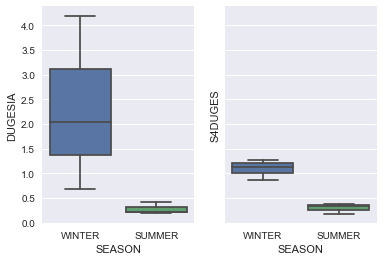

In [42]:
fig, ax = plt.subplots(1, 2, sharex=True, sharey=True)

sns.boxplot(data=curdies_agg, x='SEASON', y='DUGESIA', ax=ax[0]) # variance is non heterogeneous
sns.boxplot(data=curdies_agg, x='SEASON', y='S4DUGES', ax=ax[1]) # the 4th root transformation helps at making the variance heterogeneous

In [43]:
X = patsy.dmatrix("SEASON", data=curdies, return_type='dataframe')
X = np.asarray(X)

In [44]:
# Random effect on the intercepts
Z = patsy.dmatrix('-1 + SITE', data=curdies, return_type='dataframe')
Z = np.asarray(Z)

In [45]:
Y = np.asarray(curdies.S4DUGES)

In [46]:
with pm.Model() as model:
    
    ## Priors
    # SEASON (2 levels)
    # The values split on season have the same variance (see boxplot above)
    sigma_X = pm.HalfCauchy('sigma_X', beta=3)
    # Coefficients for WINTER and SUMMER
    beta_X = pm.Normal('beta_X', mu=0, sd=sigma_X, shape=X.shape[1])
    
    estimate_X = pm.math.dot(X, beta_X)
     
    # SITE (6 levels)
    # There are 6 different sites, 3 within SEASON
    sigma_Z = pm.HalfCauchy('sigma_Z', beta=3)
    
    # Centered version
    gamma_Z = pm.Normal('gamma_Z', mu=0, sd=sigma_Z, shape=Z.shape[1])
    
    # Non Centered version
    #gamma_Z_offset = pm.Normal('gamma_Z_offset', mu=0, sd=1, shape=Z.shape[1])
    #gamma_Z = pm.Deterministic('gamma_Z', gamma_Z_offset * sigma_Z)
    
    estimate_Z = pm.math.dot(Z, gamma_Z)
    
    ## likelihood
    estimate = estimate_X + estimate_Z
    sigma = pm.HalfCauchy('sigma', beta=5) # unexplained variability
    y_likelihood = pm.Normal('y_likelihood', mu=estimate, sd=sigma, observed=Y)
    
    trace = pm.sample(draws=5000, chains=4, step=pm.NUTS(), njobs=2, tune=1500)

C:\Miniconda3\envs\GLM_with_PyMC3\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma_log__, gamma_Z, sigma_Z_log__, beta_X, sigma_X_log__]
There were 45 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.50599902717817, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


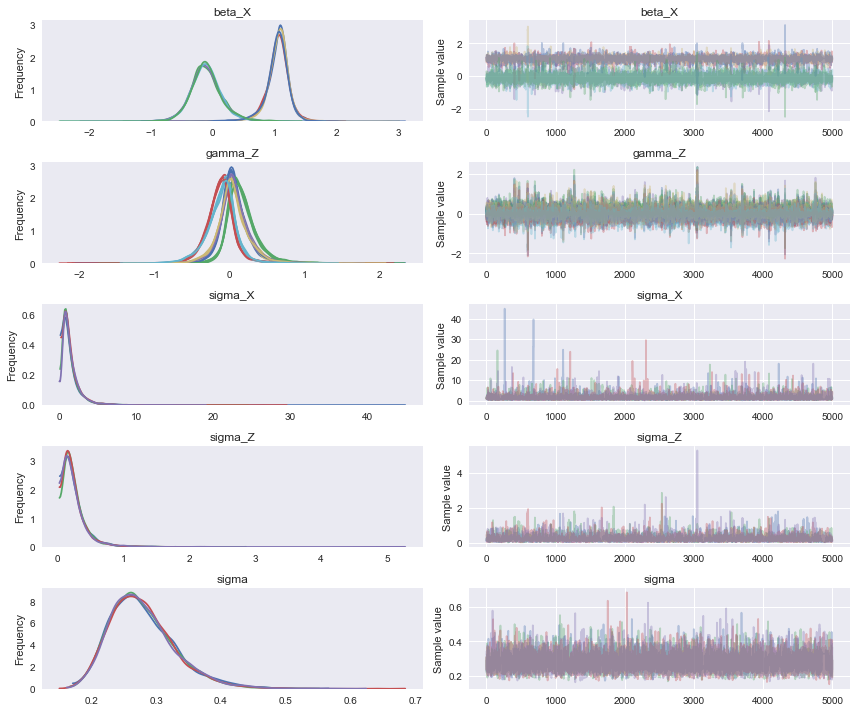

In [47]:
_ = pm.traceplot(trace)

In [48]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta_X__0,1.048227,0.196761,0.002663,0.617501,1.382057,4702.0,1.000807
beta_X__1,-0.110027,0.266429,0.003217,-0.611923,0.436107,5424.0,1.000252
gamma_Z__0,0.067320,0.203147,0.002720,-0.292601,0.496960,5092.0,1.000900
gamma_Z__1,0.166018,0.210844,0.003016,-0.213615,0.579839,4307.0,1.000726
gamma_Z__2,-0.119394,0.200886,0.002545,-0.537421,0.242081,5474.0,1.000508
gamma_Z__3,0.057511,0.208914,0.002202,-0.348173,0.486637,8149.0,1.000033
gamma_Z__4,0.055353,0.219007,0.002423,-0.381121,0.499469,7951.0,1.000061
gamma_Z__5,-0.104561,0.207517,0.002402,-0.576843,0.252131,7463.0,0.999988
sigma_X,1.554613,1.489992,0.021530,0.238376,3.862827,5168.0,1.000046
sigma_Z,0.253069,0.196538,0.003549,0.028668,0.596592,2679.0,1.000647
